In [3]:
%load_ext autoreload
%autoreload 

from preprocessing.preprocess_ucr import UCRDatasetImporter
from preprocessing.preprocess_ucr import UCRDataset
from preprocessing.preprocess_ucr import AugUCRDataset
from preprocessing.data_pipeline import build_data_pipeline
from utils import load_yaml_param_settings

from utils import time_to_timefreq, timefreq_to_time
from preprocessing.augmentations import TimeFreqAugmenter
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
config_dir = 'configs/config.yaml' #dir to config file

config = load_yaml_param_settings(config_dir)

config['dataset']['dataset_name'] = 'ECG5000'

# data pipeline
dataset_importer = UCRDatasetImporter(**config['dataset'])
batch_size = config['dataset']['batch_sizes']['stage1']
train_data_loader = build_data_pipeline(batch_size, dataset_importer, config, 'train', augment=True)
test_data_loader = build_data_pipeline(batch_size, dataset_importer, config, 'test')

augmenter = TimeFreqAugmenter(**config['augmentations']['aug_params'])

self.X_train.shape: (500, 140)
self.X_test.shape: (4500, 140)
# unique labels (train): [0 1 2 3 4]
# unique labels (test): [0 1 2 3 4]


In [6]:
for batch in test_data_loader:
    (x1, x2), y = batch
    #x_aug = augmenter(x)
    break

plt.plot(x1[0,0])

ValueError: too many values to unpack (expected 2)

In [7]:
def get_x_u():
    X = torch.tensor(train_data_loader.dataset.X)
    x = X[np.random.randint(0, X.shape[0])]
    return x, augmenter.stft(x)

def plot(x, xaug, u, uaug):
    f, a = plt.subplots(1, 3, figsize=(15, 5))
    
    # Visualize the magnitude of the original and augmented STFT representations
    a[0].imshow(np.abs(u), aspect='auto', cmap='viridis')  # You can adjust the cmap
    a[1].imshow(np.abs(uaug), aspect='auto', cmap='viridis')  # You can adjust the cmap
    
    # Plot the original and augmented signals
    a[2].plot(x, label='original')
    a[2].plot(xaug, label='augmented')  # Include the augmented signal in the plot
    a[2].legend()
    
    plt.show()

# Random Block Augmentation


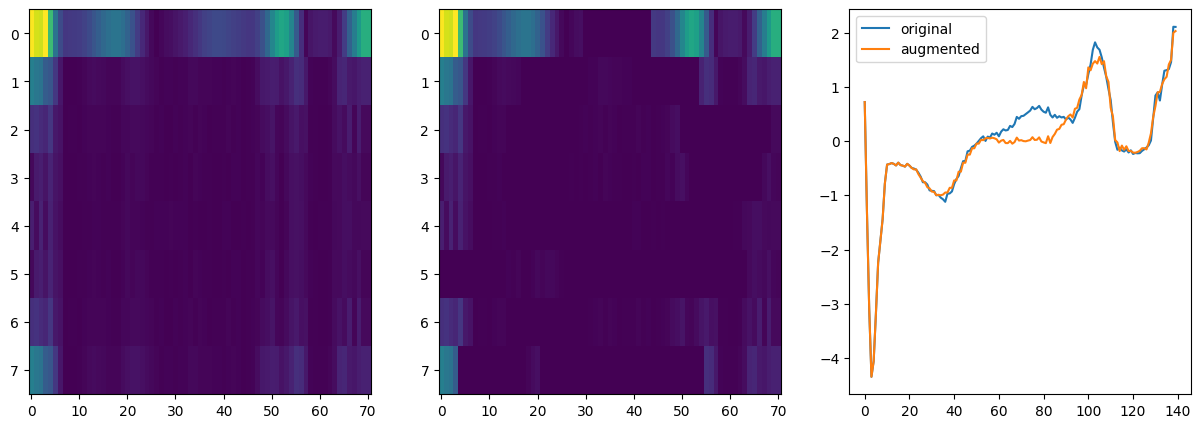

torch.Size([140]) torch.Size([140]) torch.Size([8, 71]) (8, 71)


In [91]:
x, u = get_x_u()

augmenter.update_parameters(block_size_scale=0.2, block_density=0.05)

# Apply block augmentation to the complex-valued u directly
uaug_blocks = augmenter.add_block_augmentation(u.numpy())

# Convert the augmented u back to the time domain
xaug_block = augmenter.istft(torch.from_numpy(uaug_blocks), x.shape[0])

plot(x, xaug_block, u, uaug_blocks)
print(x.shape, xaug_block.shape, u.shape, uaug_blocks.shape)

# Random band augmentation

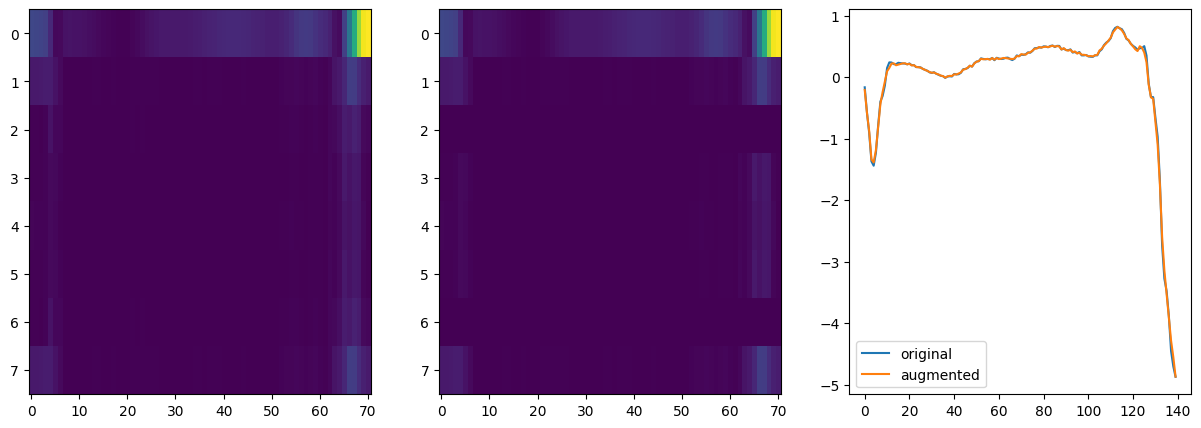

torch.Size([140]) torch.Size([140]) torch.Size([8, 71]) (8, 71)


In [94]:
x, u = get_x_u()

augmenter.update_parameters(num_bands_to_remove=2, band_scale_factor=0.2)

# Apply block augmentation to the complex-valued u directly
uaug_band = augmenter.add_band_augmentation(u.numpy())
xaug_band = augmenter.istft(torch.from_numpy(uaug_band), x.shape[0])

plot(x, xaug_band, u, uaug_band)
print(x.shape, xaug_band.shape, u.shape, uaug_band.shape)

# Random Phase Augmentation

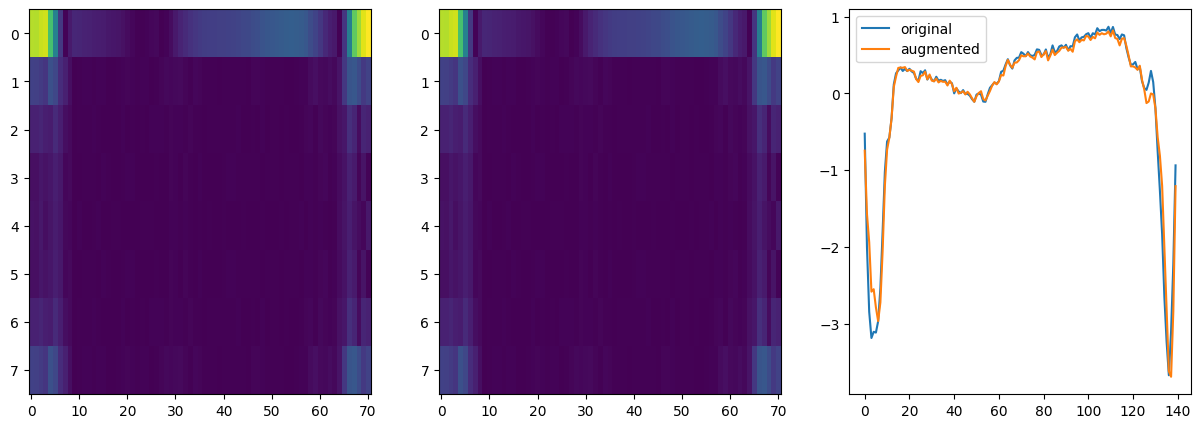

In [11]:
x, u = get_x_u()

augmenter.update_parameters(phase_max_change=np.pi/4)

uaug_phase = augmenter.add_phase_augmentation(u.numpy())
xaug_phase = augmenter.istft(torch.from_numpy(uaug_phase), x.shape[0])

plot(x, xaug_phase, u, uaug_phase)


# Random Rotation Augmentation

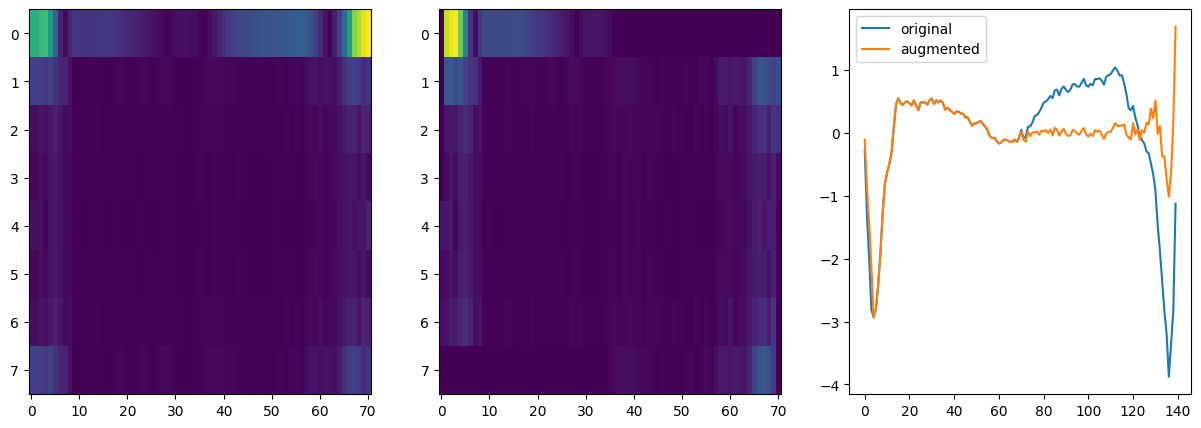

In [12]:
x, u = get_x_u()

augmenter.update_parameters(rotation_max_change=30)

uaug_rotation = augmenter.add_rotation_augmentation(u.numpy())
xaug_rotation = augmenter.istft(torch.from_numpy(uaug_rotation), x.shape[0])

plot(x, xaug_rotation, u, uaug_rotation)

# Gaussian augmentation


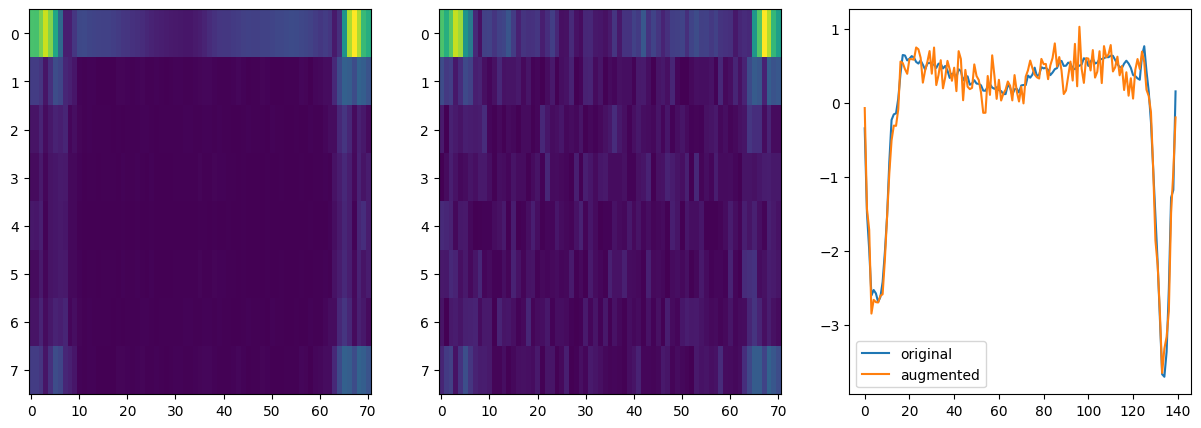

In [13]:
x, u = get_x_u()

augmenter.update_parameters(gaus_mean = 0, gaus_std = 1)

uaug_gaus = augmenter.add_gaussian_augmentation(u.numpy())
xaug_gaus = augmenter.istft(torch.from_numpy(uaug_gaus), x.shape[0])

plot(x, xaug_gaus, u, uaug_gaus)

# Random scaling

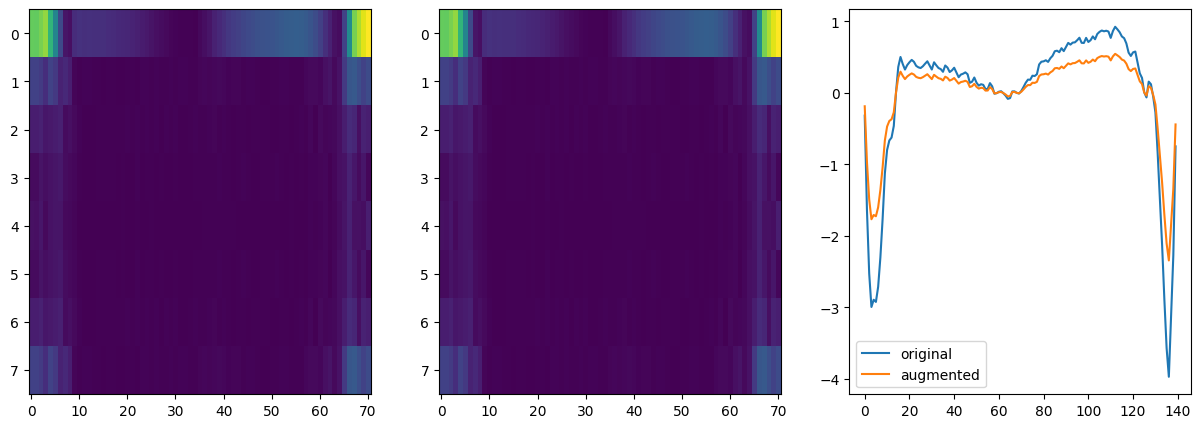

In [14]:
x, u = get_x_u()

augmenter.update_parameters(min_scale = 0.5, max_scale = 1.5)

uaug_scale = augmenter.add_scale_augmentation(u.numpy())
xaug_scale = augmenter.istft(torch.from_numpy(uaug_scale), x.shape[0])

plot(x, xaug_scale, u, uaug_scale)

# Random masks

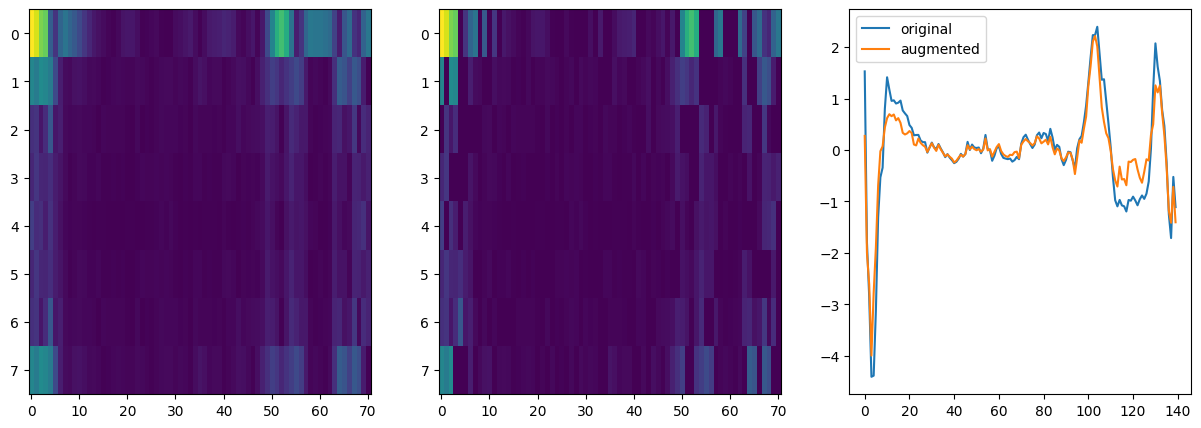

In [19]:
x, u = get_x_u()

augmenter.update_parameters(mask_density = 0.3)

uaug_mask = augmenter.add_random_masks_augmentation(u.numpy())
xaug_mask = augmenter.istft(torch.from_numpy(uaug_mask), x.shape[0])

plot(x, xaug_mask, u, uaug_mask)

# Shear Augmentation


torch.Size([8, 71])


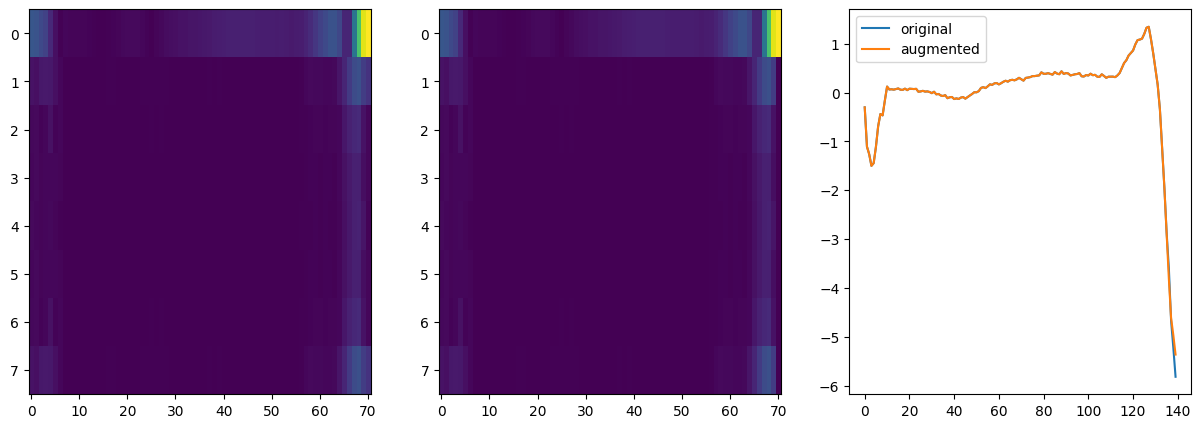

In [20]:
x, u = get_x_u()

print(u.shape)

augmenter.update_parameters(max_shear_x = 0.01, max_shear_y=0.01)

uaug_shear = augmenter.add_shear_augmentation(u.numpy())
xaug_shear = augmenter.istft(torch.from_numpy(uaug_shear), x.shape[0])

plot(x, xaug_shear, u, uaug_shear)

# Random Combination Augmentation


In [21]:
from preprocessing.augmentations import Augmenter

aug = Augmenter(**config['augmentations'])

x, u = get_x_u()
xaug, combination = aug.augment(x, return_combinations=True)

print(combination)
plt.plot(x)
plt.plot(xaug)

AttributeError: 'TimeAugmenter' object has no attribute 'noise_window_rate'